요구사항 1
---
titamic_dataset.py 분석

In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from sklearn.preprocessing import LabelEncoder

In [4]:
class TitanicDataset(Dataset): # 데이터 셋을 상속받아 데이터를 load 하고 처리하기 쉽게 해줌
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X) # floattensor로 변환해 저장하고 feature와 target 받음.
    self.y = torch.LongTensor(y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    target = self.y[idx]
    return {'input': feature, 'target': target}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str

In [5]:
class TitanicTestDataset(Dataset): # Test dataset에는 y 즉 target 값이 없으므로
  def __init__(self, X): # x(입력) 값만 처리
    self.X = torch.FloatTensor(X)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    return {'input': feature}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}".format(
      len(self.X), self.X.shape
    )
    return str

In [9]:
def get_preprocessed_dataset_1(all_df):
    #all_df[["Pclass", "Fare"]] = 데이터셋에서 pclass, fare 열만 선택
    #groupby("Pclass") = pclass 열 기준으로 데이터를 groupby
    #즉, 1,2,3 등급별로 그룹이 만들어짐.
    #mean()은 전체 fare의 평균을 구함
    #reset_index()은 열로 변환하여 데이터프레임 형태로 만들어줌
    #현재 모습이 (1, xx) (2, xx) (3, xx)로 묵여있다면 index를 0부터 다시 매겨줌-> 0 (1, xx) , 1 (2, xx) 2 (3, xx) 이런식 
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    
    Fare_mean.columns = ["Pclass", "Fare_mean"]#열이름을 pclass, fare_mean 으로 변셩
    #all_df 기존 데이터셋과 방금 만든 fare_mean 열을 merge()를 통해 데이터셋 결합
    #on="Pclass"열 기준으로 left 방식, 즉 왼쪽 모든 데이터를 유지하면서 병합
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    #all_df["Fare"].isnull() Fare 값이 없는 데이터를 찾아
    #loc으로 맞는 행을 선택하고, 
    # #all_df["Fare"] = all_df["Fare_mean"] 없는 Fare 값을 Fare_mean 값으로 대체
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]

    return all_df

In [11]:
def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    # 이름 자체는 학습시킬때에 필요가 없는 데이터 지만 존칭은 나이를 예측할 수 있는 지표가 될 수 있음
    # 존칭과 나이를 합쳐서 그 존칭을 가진 사람의 평균 나이를 구할 수 있음.
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "honorific", "name"]
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["honorific"] = name_df["honorific"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    all_df = pd.concat([all_df, name_df], axis=1)

    return all_df

In [13]:
def get_preprocessed_dataset_3(all_df):
    # honorific별 Age의 중앙값을 구하고 반올림하여 정수로 만들어준 후 재 인덱싱 진행
    # 존칭(Mr,Mrs)으로 그룹을 나눠 없는 데이터 셋에 중앙값인 나이를 추가.
    #방식은 fare때 처리했던 방식과 유사함.
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ]
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]

    # drop()을 사용하여 honorific_age_mean 열 삭제.    
    all_df = all_df.drop(["honorific_age_mean"], axis=1)

    return all_df

In [15]:
def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가 -> 기존 데이터셋엔 존재하지 않은 col
    #가족의 수 = 부모와 자녀 + 형제자매와 배우자 수
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    #가족수가 0이면 alone 새 열을 만들어 1 입력
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    #alone 값이 0 즉 결측값이면 0으로 채워줌
    #all_df["alone"].fillna(0, inplace=True) 혼자가 아닌 탑승객들은 0으로 표현
    all_df["alone"] = all_df["alone"].fillna(0)

    # 학습에 사용되지 않는 컬럼들을 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df

In [17]:
def get_preprocessed_dataset_5(all_df):
    # honorific 값 개수 줄이는 과정
    # ~(...)은 부정 연산자로 안에 조건이 들어감 -> Mr, Miss, Mrs, Master가 아니면 other로 대체
    all_df.loc[
    ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
    ),
    "honorific"
    ] = "other"

    #embarked 값이 없는경우 missing이라는 값을 입력
    all_df["Embarked"] = all_df["Embarked"].fillna("missing")
    return all_df

In [19]:

def get_preprocessed_dataset_6(all_df):
    
    # all_df의 열중 dtype이 "object"인 열만 가져와 category_feature에 입력
    category_features = all_df.columns[all_df.dtypes == "object"]
    
    #각 범주형 데이터들을 고유한 정수로 변환해주는 for문
    for category_feature in category_features: # 범주형 데이터들을 하나씩 뽑아서
        #범주형 데이터를 수치형으로 반환해주는 라이브러리
        # 범주형 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
        le = LabelEncoder()
        #범주형 데이터면
        if all_df[category_feature].dtypes == "object":
          #고유한 정수로 맵핑
          le = le.fit(all_df[category_feature])
          #범주형 데이터를 수치형으로 변환.
          all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df

In [21]:
#데이터셋의 전처리 파트 정의
def get_preprocessed_dataset():
    #CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
    # __file__변수로는 파일을 정확하게 불러올수 없기에 직접 경로를 작성하는 것으로 데이터를 가져와야 함.
    
    CURRENT_FILE_PATH = os.getcwd()  # 현재 파일이 위치한 디렉토리 경로 사용
    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv") # 현재 실행위치의 디렉토리안의 파일에 연결
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    train_df = pd.read_csv(train_data_path) # 데이터 load
    test_df = pd.read_csv(test_data_path)

    #train 데이터셋과 test 데이터셋을 한번에 전처리하기 위해 concat으로 이어 붙임
    #train에는 label인 survived가 있지만 test에는 없는걸 고려해서 처리해야함. 
    all_df = pd.concat([train_df, test_df], sort=False)

    all_df = get_preprocessed_dataset_1(all_df) #fare 결측값 처리

    all_df = get_preprocessed_dataset_2(all_df) #이름 분리

    all_df = get_preprocessed_dataset_3(all_df) # age 결측값 추가

    all_df = get_preprocessed_dataset_4(all_df) # 가족, 필요없는 특징 제거

    all_df = get_preprocessed_dataset_5(all_df) # embarked 결측값 추가 및 honorific 값 개수 줄이기

    all_df = get_preprocessed_dataset_6(all_df) # 범주형 특징값들을 고유한 수치로 맵핑

    #concat으로 붙여놨던 train 데이터와 test 데이터를 분리하는 작업 -> test 데이터 셋에는 survived 열에(feature) value가 존재하지 않기에 그걸 이용
    # survived 값이 있는 데이터를 train x에 추가.
    #drop을 사용해 target 인 survived를 제거
    #reset_index(drop=True) 기존 인덱스에 새로운 열을 추가하지 않고 완전 제거 후 인덱스 재설정
    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]

    # ~ 부정 연산자만 빼서 survived가 없는 데이터를 test x에 추가.
    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    # 입력과 출력(target)으로 데이터 셋 구성
    dataset = TitanicDataset(train_X.values, train_y.values)
    #print(dataset)
    #데이터 셋을 8:2로 train 데이터와 validation 데이터를 분리
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    test_dataset = TitanicTestDataset(test_X.values)
    #print(test_dataset)
    # 데이터 셋을 train, validation, test로 분리후 반환
    return train_dataset, validation_dataset, test_dataset

In [23]:
#모델 구조 정의
class MyModel(nn.Module):
  #n_input = 입력 특징의 개수
  #n_output = survived 여부 즉 0 or 1
  def __init__(self, n_input, n_output): # 모델 구조 정의
    super().__init__()

    #순차적으로 레이어 정의
    #Fully Connected Layer로 설정 활성화 함수는 Relu를 사용
    # x의 특징 수 만큼 입력으로 받아
    # 30개로 선형 변환 후 활성함수 적용, 히든레이어 하나 더 지나고 최종 output레이어를 거치면 0 or 1이 출력됨.
    self.model = nn.Sequential(
      nn.Linear(n_input, 30),
      nn.ReLU(),
      nn.Linear(30, 30),
      nn.ReLU(),
      nn.Linear(30, n_output),
    )

  def forward(self, x):
    x = self.model(x)
    return x

In [25]:
def test(test_data_loader):
  print("[TEST]")
  #데이터를 배치 단위로 반복
  batch = next(iter(test_data_loader))
  print("{0}".format(batch['input'].shape))
  # 특징 수 11개와 0 or 1을 출력하는 모델 생성
  my_model = MyModel(n_input=11, n_output=2)

  #입력데이터를 넣어 예측을 수행.
  output_batch = my_model(batch['input'])
  #dim 1 즉, 0 or 1 중 더 예측값이 높은거 하나 선택
  prediction_batch = torch.argmax(output_batch, dim=1)

  #예측한 값 출력
  #for idx, prediction in enumerate(prediction_batch, start=892):
  #    print(idx, prediction.item())

In [27]:
if __name__ == "__main__": # 실행
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

  print("train_dataset: {0}, validation_dataset.shape: {1}, test_dataset: {2}".format(
    len(train_dataset), len(validation_dataset), len(test_dataset)
  ))
  print("#" * 50, 1)

  for idx, sample in enumerate(train_dataset):
    print("{0} - {1}: {2}".format(idx, sample['input'], sample['target']))

  print("#" * 50, 2)
  # 잘 만들어진 데이터를 load
  train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=True)
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

  print("[TRAIN]")
  for idx, batch in enumerate(train_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("[VALIDATION]")
  for idx, batch in enumerate(validation_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("#" * 50, 3)

  test(test_data_loader)

train_dataset: 713, validation_dataset.shape: 178, test_dataset: 418
################################################## 1
0 - tensor([ 3.0000,  1.0000, 42.0000,  0.0000,  0.0000,  7.6500,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
1 - tensor([ 3.0000,  1.0000, 29.0000,  8.0000,  2.0000, 69.5500,  2.0000, 13.3029,
         2.0000, 10.0000,  0.0000]): 0
2 - tensor([ 2.0000,  0.0000, 32.0000,  0.0000,  0.0000, 13.0000,  2.0000, 21.1792,
         3.0000,  0.0000,  1.0000]): 1
3 - tensor([ 2.0000,  0.0000, 24.0000,  2.0000,  1.0000, 27.0000,  2.0000, 21.1792,
         3.0000,  3.0000,  0.0000]): 1
4 - tensor([ 3.0000,  1.0000, 40.0000,  0.0000,  0.0000,  7.8958,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
5 - tensor([ 3.0000,  1.0000, 17.0000,  0.0000,  0.0000,  7.1250,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
6 - tensor([ 3.0000,  1.0000, 51.0000,  0.0000,  0.0000,  7.0542,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
7 - tensor([ 1.00

요구사항 2
---
딥러닝 모델 훈련코드 및 activation function 변경

In [30]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [31]:
from torch import optim
from datetime import datetime
import wandb
import sys

In [32]:
class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        
        self.model = nn.Sequential(
            #wandb.config.n_hidden_unit_list[0] 에서 설정된 첫 번째 히든레이어 노드 수
            nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
            nn.ReLU(),
            nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
            nn.ReLU(),
            nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [36]:
def get_model_and_optimizer():
    my_model = MyModel(n_input=11, n_output=2)

    #스토캐스틱 그라디언트 디센트를 사용하여 모델 학습, 러닝 레이트는 wandb.config.learning_rate
    optimizer = optim.SGD(my_model.parameters(), lr=wandb.config.learning_rate)
    return my_model, optimizer

In [38]:
def training_loop(model, optimizer, train_data_loader, validation_data_loader):
    n_epochs = wandb.config.epochs # 반복 횟수
    loss_fn = nn.CrossEntropyLoss()  # 이진 분류 문제이므로 CrossEntropyLoss 사용
    next_print_epoch = 100 # 100번마다 loss 출력

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        num_trains = 0
        for train_batch in train_data_loader:
            #target을 예측하는 학습 수행
            input, target = train_batch['input'], train_batch['target']
            output_train = model(input)
            #loss 계산
            loss = loss_fn(output_train, target)
            loss_train += loss.item()
            num_trains += 1

            #그라디언트 초기화
            optimizer.zero_grad()
            # 그라디언트 계산
            loss.backward()
            #SGD
            optimizer.step()

        loss_validation = 0.0
        num_validations = 0

        #computation graph x
        #validation 계산, train과 동일한 알고리즘이지만 업데이트는 하지 않음.
        with torch.no_grad():
            for validation_batch in validation_data_loader:
                input, target = validation_batch['input'], validation_batch['target']
                output_validation = model(input)
                loss = loss_fn(output_validation, target)
                loss_validation += loss.item()
                num_validations += 1

        wandb.log({
            "Epoch": epoch,
            "Training loss": loss_train / num_trains,
            "Validation loss": loss_validation / num_validations
        })
        #100회마다 진행
        if epoch >= next_print_epoch:
            print(
                f"Epoch {epoch}, "
                f"Training loss {loss_train / num_trains:.4f}, "
                f"Validation loss {loss_validation / num_validations:.4f}"
            )
            next_print_epoch += 100

In [40]:
def test_and_create_submission(model, test_data_loader):
    model.eval()  # 모델을 평가 모드로 전환, 가중치를 업데이트 하지 않음
    all_predictions = []
    passenger_ids = list(range(892, 892 + len(test_data_loader.dataset)))  # Titanic 테스트 데이터의 승객 ID는 892부터 시작

    #업데이트를 하지 않기 때문에 no_grad
    with torch.no_grad():
        for test_batch in test_data_loader:
            input = test_batch['input']  # TitanicTestDataset을 사용하여 'input' 데이터를 가져옴
            output = model(input)
            predictions = torch.argmax(output, dim=1).cpu().numpy()  # 0 or 1 중 가장 높은 확률의 클래스를 예측
            all_predictions.extend(predictions)

    # submission.csv 생성
    submission_df = pd.DataFrame({
        #형식에 맞게
        'PassengerId': passenger_ids,
        'Survived': all_predictions
    })
    
    #submission_df.to_csv('submission_test.csv', index=False)
    #print("submission_test.csv 파일이 생성되었습니다!")

In [42]:
def main(args):
    #현재 시간 기록
    current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    #모델에 설정할 값들을 담은 딕셔너리
    #에포크, 배치사이즈, 러닝 레이트, 히든 유닛 개수 등 포함되어 있음
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'learning_rate': 1e-3,
        'n_hidden_unit_list': [20, 20],
    }

    #wandb 모델의 초기값 생성
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project="homework_02_",
        notes="Titanic Dataset experiment",
        tags=["my_model", "titanic"],
        name=current_time_str,
        config=config
    )
    print(args)
    print(wandb.config)

    #모델과 옵티마이저 생성
    model, optimizer = get_model_and_optimizer()

    print("#" * 50, 1)

    #모델 train 시작.
    training_loop(
        model=model,
        optimizer=optimizer,
        train_data_loader=train_data_loader,
        validation_data_loader=validation_data_loader
    )
    #train 끝
    #test 실행
    test_and_create_submission(model, test_data_loader)

    wandb.finish()

In [44]:
if __name__ == "__main__":
    # Jupyter Notebook 환경을 확인하여 argparse를 우회.
    if "ipykernel_launcher" in sys.argv[0]:
        # 기본값을 설정
        class Args:
            wandb = True
            batch_size = 512
            epochs = 1000 # Early stopping을 위해 epochs를 1000으로 설정

        args = Args() # args 추가
        main(args) # 실행

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lss523012 (lss523012-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin


{'epochs': 1000, 'batch_size': 512, 'learning_rate': 0.001, 'n_hidden_unit_list': [20, 20]}
################################################## 1
Epoch 100, Training loss 0.5734, Validation loss 0.5625
Epoch 200, Training loss 0.5486, Validation loss 0.5407
Epoch 300, Training loss 0.5163, Validation loss 0.5074
Epoch 400, Training loss 0.4909, Validation loss 0.5054
Epoch 500, Training loss 0.4778, Validation loss 0.4570
Epoch 600, Training loss 0.4532, Validation loss 0.4919
Epoch 700, Training loss 0.4797, Validation loss 0.5240
Epoch 800, Training loss 0.4761, Validation loss 0.5234
Epoch 900, Training loss 0.4490, Validation loss 0.4772
Epoch 1000, Training loss 0.4205, Validation loss 0.4843


Epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
Training loss,███▇▇▇▇▇▇▇▅▅▅▅▄▄▃▃▂▃▄▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▃▁▁
Validation loss,▆▅▅▆▅▅▅▄▄▄▃▄▃▅▂▃▃█▄▆▂▂▅▁▃▂▇▁▂▂▂▃▅▇▂▅▁▂▂▁
Epoch,1000
Training loss,0.42045
Validation loss,0.48426


ReLu 결과
---

https://wandb.ai/lss523012-korea-university-of-technology-and-education/homework_02_/runs/tvqihvqa?nw=nwuserlss523012

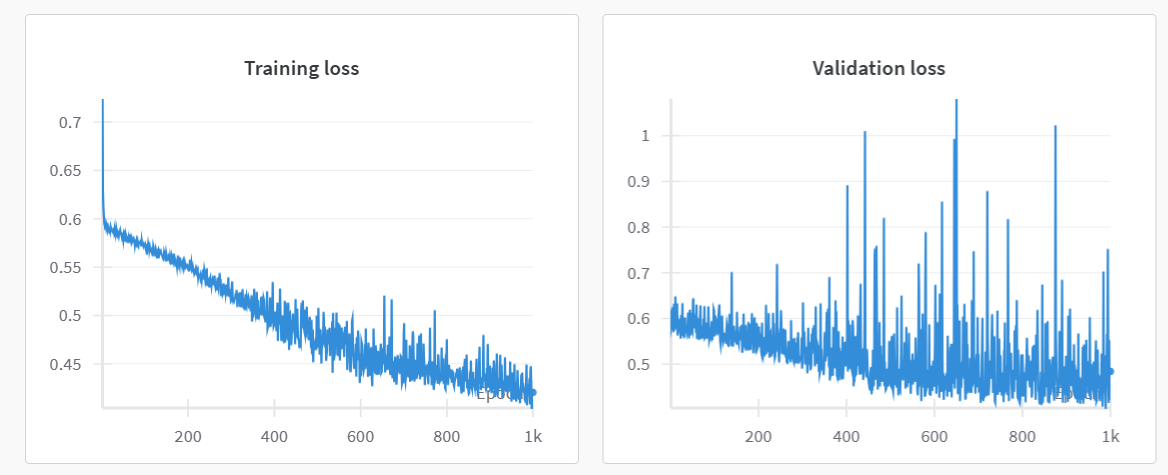


In [47]:
class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        
        self.model = nn.Sequential(
            #wandb.config.n_hidden_unit_list[0] 에서 설정된 첫 번째 히든레이어 노드 수
            nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
            nn.ELU(),
            nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
            nn.ELU(),
            nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
        )

    def forward(self, x):
        x = self.model(x)
        return x

if __name__ == "__main__":
    # Jupyter Notebook 환경을 확인하여 argparse를 우회.
    if "ipykernel_launcher" in sys.argv[0]:
        # 기본값을 설정
        class Args:
            wandb = True
            batch_size = 512
            epochs = 2000 # Early stopping을 위해 epochs를 2000으로 설정

        args = Args() # args 추가
        main(args) # 실행

{'epochs': 2000, 'batch_size': 512, 'learning_rate': 0.001, 'n_hidden_unit_list': [20, 20]}
################################################## 1
Epoch 100, Training loss 0.5633, Validation loss 0.5321
Epoch 200, Training loss 0.5393, Validation loss 0.5215
Epoch 300, Training loss 0.5140, Validation loss 0.5229
Epoch 400, Training loss 0.4799, Validation loss 0.4827
Epoch 500, Training loss 0.4533, Validation loss 0.5043
Epoch 600, Training loss 0.4411, Validation loss 0.4608
Epoch 700, Training loss 0.4294, Validation loss 0.4268
Epoch 800, Training loss 0.4262, Validation loss 0.5141
Epoch 900, Training loss 0.4188, Validation loss 0.5043
Epoch 1000, Training loss 0.4210, Validation loss 0.4388
Epoch 1100, Training loss 0.4075, Validation loss 0.4310
Epoch 1200, Training loss 0.4086, Validation loss 0.4638
Epoch 1300, Training loss 0.4096, Validation loss 0.5620
Epoch 1400, Training loss 0.4192, Validation loss 0.4837
Epoch 1500, Training loss 0.3992, Validation loss 0.4566
Epoch 160

Epoch,▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇████
Training loss,███▇▆▄▄▃▃▃▃▃▂▃▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▂▁▁▁▁▁
Validation loss,▆▇▄▄▄▅▆▅▅▃▃▄▂▂▃▂▅█▂▃▂▄▂▂▁▆▇▂▂▅▂▁▁▆▁▇▃▂▂▂
Epoch,2000
Training loss,0.39989
Validation loss,0.40577


ELu 결과
---

https://wandb.ai/lss523012-korea-university-of-technology-and-education/homework_02_/runs/x1kzj1iy?nw=nwuserlss523012

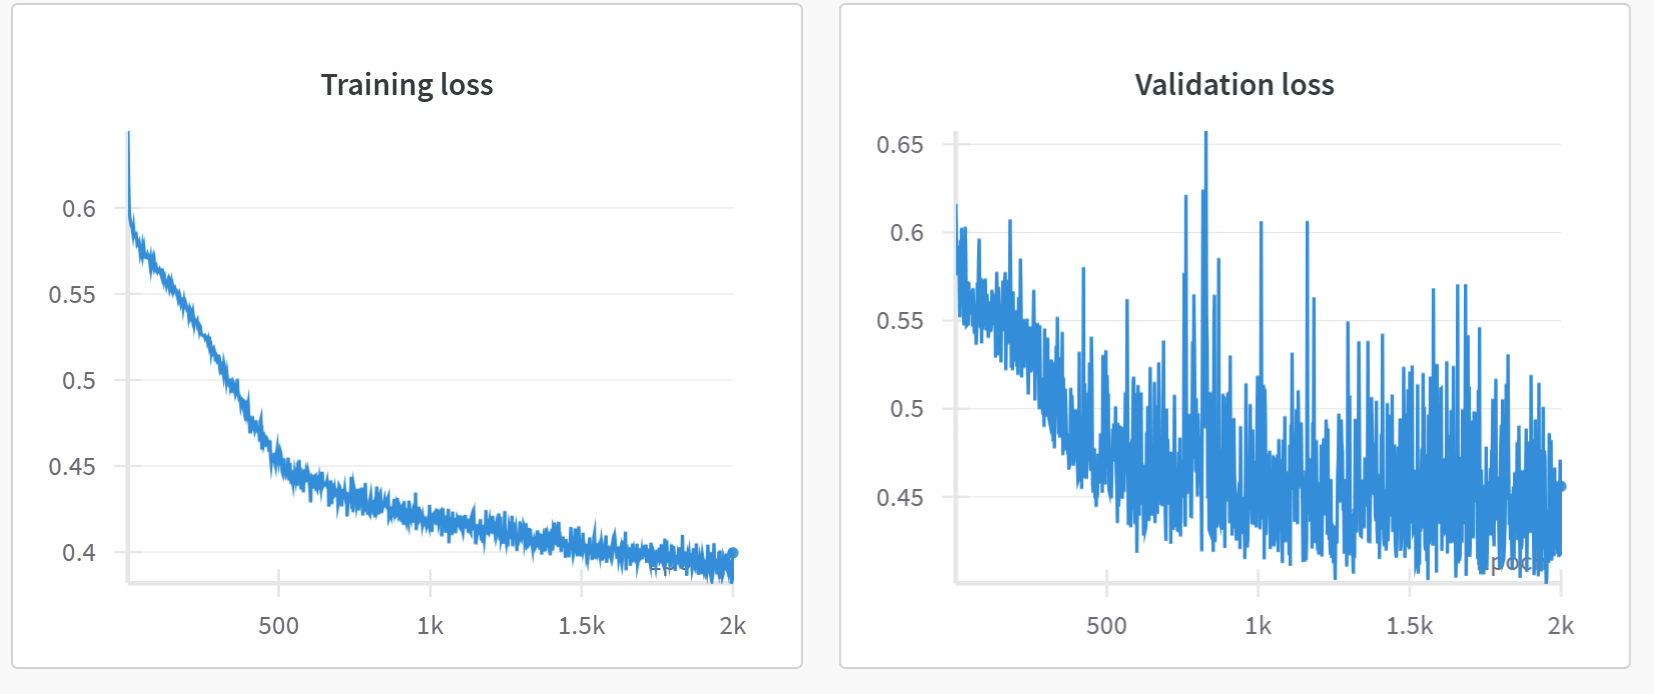

In [49]:
class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        
        self.model = nn.Sequential(
            #wandb.config.n_hidden_unit_list[0] 에서 설정된 첫 번째 히든레이어 노드 수
            nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
            nn.LeakyReLU(),
            nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
            nn.LeakyReLU(),
            nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
        )

    def forward(self, x):
        x = self.model(x)
        return x

if __name__ == "__main__":
    # Jupyter Notebook 환경을 확인하여 argparse를 우회.
    if "ipykernel_launcher" in sys.argv[0]:
        # 기본값을 설정
        class Args:
            wandb = True
            batch_size = 512
            epochs = 2000 # Early stopping을 위해 epochs를 2000으로 설정

        args = Args() # args 추가
        main(args) # 실행

{'epochs': 2000, 'batch_size': 512, 'learning_rate': 0.001, 'n_hidden_unit_list': [20, 20]}
################################################## 1
Epoch 100, Training loss 0.5639, Validation loss 0.5847
Epoch 200, Training loss 0.5516, Validation loss 0.5487
Epoch 300, Training loss 0.5330, Validation loss 0.5818
Epoch 400, Training loss 0.5090, Validation loss 0.6097
Epoch 500, Training loss 0.4863, Validation loss 0.4823
Epoch 600, Training loss 0.4562, Validation loss 0.4612
Epoch 700, Training loss 0.4405, Validation loss 0.4612
Epoch 800, Training loss 0.4330, Validation loss 0.4414
Epoch 900, Training loss 0.4331, Validation loss 0.4651
Epoch 1000, Training loss 0.4127, Validation loss 0.5184
Epoch 1100, Training loss 0.4043, Validation loss 0.4347
Epoch 1200, Training loss 0.4147, Validation loss 0.4885
Epoch 1300, Training loss 0.3864, Validation loss 0.4823
Epoch 1400, Training loss 0.3993, Validation loss 0.4879
Epoch 1500, Training loss 0.3848, Validation loss 0.4155
Epoch 160

Epoch,▁▁▁▁▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
Training loss,███▇▇▇▆▆▆▆▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▂▁▂▂▁▁▂▁▁▁▁
Validation loss,▄▄▄▅▄▄▄▄▄▄▃▄▅▄▂█▁▂▁▂▆▂▄▂▅▁▂▄▂▂▃▂▁▃▂▂▁▂▁▂
Epoch,2000
Training loss,0.39122
Validation loss,0.41355


LReLu 결과
---

https://wandb.ai/lss523012-korea-university-of-technology-and-education/homework_02_/runs/ek9qtn4r?nw=nwuserlss523012

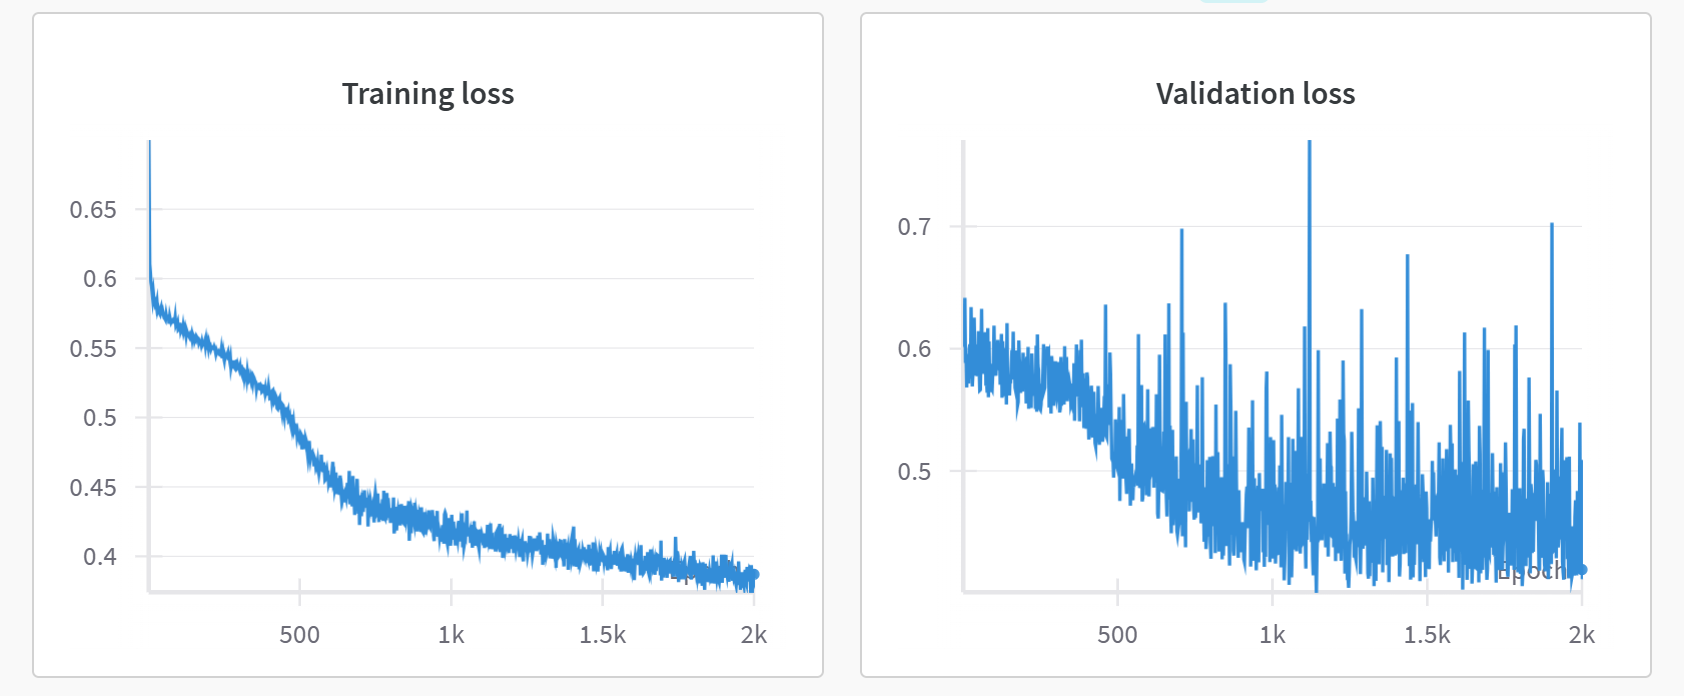

In [51]:
class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        
        self.model = nn.Sequential(
            #wandb.config.n_hidden_unit_list[0] 에서 설정된 첫 번째 히든레이어 노드 수
            nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
            nn.PReLU(num_parameters=1, init=0.25),
            nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
            nn.PReLU(num_parameters=1, init=0.25),
            nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
        )

    def forward(self, x):
        x = self.model(x)
        return x

if __name__ == "__main__":
    # Jupyter Notebook 환경을 확인하여 argparse를 우회.
    if "ipykernel_launcher" in sys.argv[0]:
        # 기본값을 설정
        class Args:
            wandb = True
            batch_size = 512
            epochs = 2000 # Early stopping을 위해 epochs를 2000으로 설정

        args = Args() # args 추가
        main(args) # 실행

{'epochs': 2000, 'batch_size': 512, 'learning_rate': 0.001, 'n_hidden_unit_list': [20, 20]}
################################################## 1
Epoch 100, Training loss 0.5747, Validation loss 0.5906
Epoch 200, Training loss 0.5648, Validation loss 0.5625
Epoch 300, Training loss 0.5439, Validation loss 0.5674
Epoch 400, Training loss 0.5253, Validation loss 0.5840
Epoch 500, Training loss 0.5060, Validation loss 0.5211
Epoch 600, Training loss 0.4925, Validation loss 0.5352
Epoch 700, Training loss 0.4570, Validation loss 0.5327
Epoch 800, Training loss 0.4637, Validation loss 0.4995
Epoch 900, Training loss 0.4505, Validation loss 0.4361
Epoch 1000, Training loss 0.4325, Validation loss 0.4842
Epoch 1100, Training loss 0.4273, Validation loss 0.5172
Epoch 1200, Training loss 0.4082, Validation loss 0.4675
Epoch 1300, Training loss 0.4143, Validation loss 0.5414
Epoch 1400, Training loss 0.3941, Validation loss 0.6062
Epoch 1500, Training loss 0.3988, Validation loss 0.4613
Epoch 160

Epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
Training loss,█▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁
Validation loss,▅▄▄▆▄▄▅▆▄▅▅▄▃▃▂▂▂▃▂▆▃▄▃▂▅▂▁▂▃▁▂▆▅▃█▃▁▄▁▂
Epoch,2000
Training loss,0.38506
Validation loss,0.49105


PReLu 결과
---

https://wandb.ai/lss523012-korea-university-of-technology-and-education/homework_02_/runs/s36ognwg?nw=nwuserlss523012

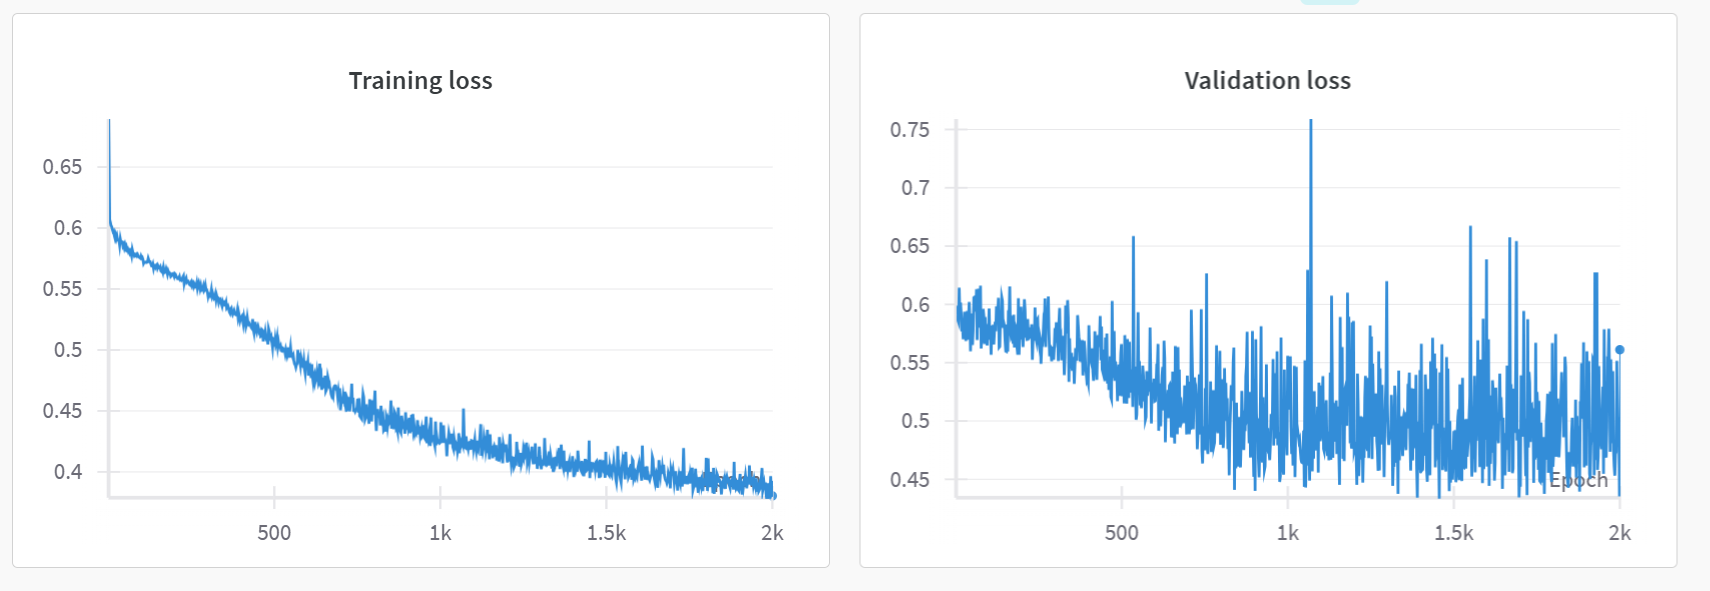

요구사항 3
---
test 및 submission.csv 생성
Relu를 사용하는 것보다 ELU를 사용하는 것이 validation loss와 train loss간의 차이가 적고
loss의 감소율도 다른 활성함수보다 좋다고 생각하여 ELU로 활성함수 변경하여 모델을 만들었습니다.

In [55]:
def training_loop(model, optimizer, train_data_loader, validation_data_loader, args):
    n_epochs = wandb.config.epochs
    loss_fn = nn.CrossEntropyLoss()
    best_validation_loss = float('inf')
    patience_counter = 0  # Early stopping을 위한 patience 카운터
    next_print_epoch = 100 # 100번마다 출력

    for epoch in range(1, n_epochs + 1):
        model.train()  # 학습 모드 전환
        loss_train = 0.0
        num_trains = 0
        for train_batch in train_data_loader:
            input, target = train_batch['input'], train_batch['target']
            output_train = model(input)
            loss = loss_fn(output_train, target)
            loss_train += loss.item()
            num_trains += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % args.validation_intervals == 0:  # 10번마다 검증 실행
            model.eval()  # 평가 모드 전환
            loss_validation = 0.0
            num_validations = 0
            with torch.no_grad():
                for validation_batch in validation_data_loader:
                    input, target = validation_batch['input'], validation_batch['target']
                    output_validation = model(input)
                    loss = loss_fn(output_validation, target)
                    loss_validation += loss.item()
                    num_validations += 1

            avg_validation_loss = loss_validation / num_validations
            wandb.log({
                "Epoch": epoch,
                "Training loss": loss_train / num_trains,
                "Validation loss": avg_validation_loss
            })

            # Early stopping 조건 확인
            if avg_validation_loss + 0.00001< best_validation_loss:
                best_validation_loss = avg_validation_loss
                patience_counter = 0  # 성능이 개선되면 patience 초기화
            else:
                patience_counter += 1  # 개선되지 않으면 카운터 증가

            if patience_counter >= args.early_stop_patience:  # patience 초과 시 학습 종료
                print(f"Early stopping at epoch {epoch}. Best validation loss: {best_validation_loss:.4f}")
                break
            if epoch >= next_print_epoch:
                print(
                    f"Epoch {epoch}, "
                    f"Training loss {loss_train / num_trains:.4f}, "
                    f"Validation loss {loss_validation / num_validations:.4f}"
                )
                next_print_epoch += 100

class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        
        self.model = nn.Sequential(
            #wandb.config.n_hidden_unit_list[0] 에서 설정된 첫 번째 히든레이어 노드 수
            nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
            nn.ELU(),
            nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
            nn.ELU(),
            nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
        )

    def forward(self, x):
        x = self.model(x)
        return x

def main(args):
    #현재 시간 기록
    current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    #모델에 설정할 값들을 담은 딕셔너리
    #에포크, 배치사이즈, 러닝 레이트, 히든 유닛 개수 등 포함되어 있음
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'learning_rate': 1e-3,
        'n_hidden_unit_list': [20, 20],
    }

    #wandb 모델의 초기값 생성
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project="my_model_training",
        notes="Titanic Dataset experiment",
        tags=["my_model", "titanic"],
        name=current_time_str,
        config=config
    )
    print(args)
    print(wandb.config)

    #모델과 옵티마이저 생성
    model, optimizer = get_model_and_optimizer()

    print("#" * 50, 1)

    #모델 train 시작.
    training_loop(
        model=model,
        optimizer=optimizer,
        train_data_loader=train_data_loader,
        validation_data_loader=validation_data_loader,
        args=args # args 추가
    )
    #train 끝
    #test 실행
    test_and_create_submission(model, test_data_loader)

    wandb.finish()

if __name__ == "__main__":
    if "ipykernel_launcher" in sys.argv[0]:
        # 기본값을 설정
        class Args:
            wandb = True
            batch_size = 512
            epochs = 2000 # Early stopping을 위해 epochs를 2000으로 설정
            validation_intervals = 10
            early_stop_patience = 20

        args = Args() # args 추가
        main(args) # 실행

{'epochs': 2000, 'batch_size': 512, 'learning_rate': 0.001, 'n_hidden_unit_list': [20, 20]}
################################################## 1
Epoch 100, Training loss 0.5596, Validation loss 0.5764
Epoch 200, Training loss 0.5381, Validation loss 0.6279
Epoch 300, Training loss 0.5264, Validation loss 0.5374
Epoch 400, Training loss 0.5054, Validation loss 0.5751
Epoch 500, Training loss 0.4760, Validation loss 0.5164
Epoch 600, Training loss 0.4477, Validation loss 0.5626
Epoch 700, Training loss 0.4347, Validation loss 0.4483
Epoch 800, Training loss 0.4264, Validation loss 0.5735
Epoch 900, Training loss 0.4222, Validation loss 0.4605
Epoch 1000, Training loss 0.4272, Validation loss 0.4708
Early stopping at epoch 1040. Best validation loss: 0.4215


Epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
Training loss,██▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▂▃▂▂▂▂▂▂▁▂▂▂▂▂▁▁▂▁▁▁
Validation loss,▇▆▆▆▆▅▇▆▅▅▆▅▅▄▅▆▅▄▄▅▃▄▄▃▃▂▂▃▄▂▁▃▃▅▄█▃▃▁▂
Epoch,1040
Training loss,0.4168
Validation loss,0.46571


test 데이터셋을 사용하여 test한 결과
---

https://wandb.ai/lss523012-korea-university-of-technology-and-education/my_model_training/runs/8a78gzax?nw=nwuserlss523012

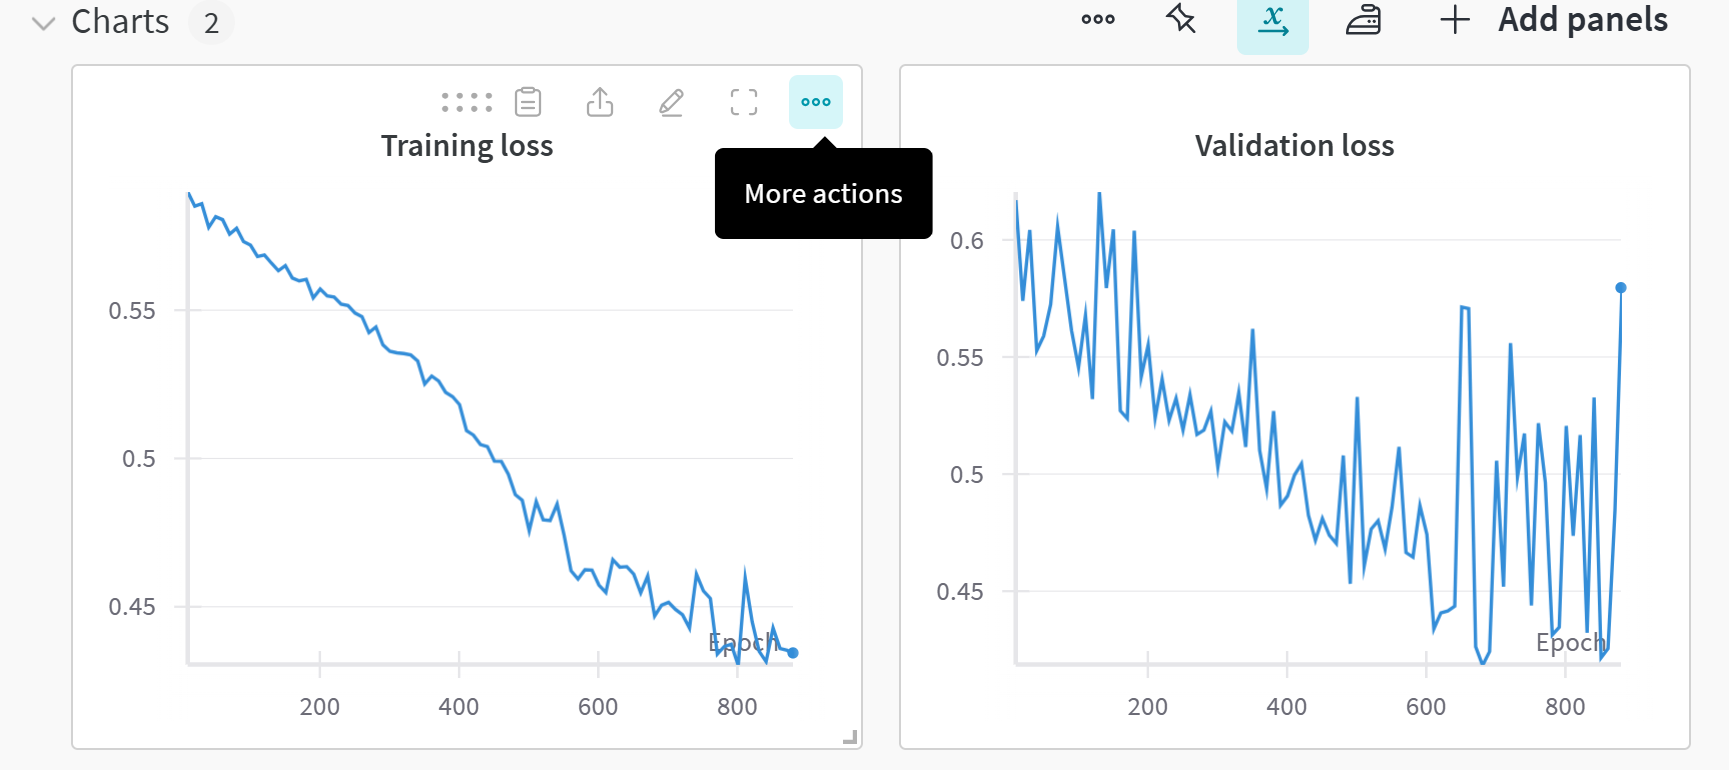

요구사향 4
---
submission.csv 제출및 등수 확인
활성함수는 ELU로 선택하고 히든 레이어 층을 1개 더 늘려서 진행함.

In [59]:
class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        
        self.model = nn.Sequential(
            #wandb.config.n_hidden_unit_list[0] 에서 설정된 첫 번째 히든레이어 노드 수
            nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
            nn.ELU(),
            
            nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
            nn.ELU(),

            nn.Linear(wandb.config.n_hidden_unit_list[1], wandb.config.n_hidden_unit_list[2]),
            nn.ELU(),
            
            nn.Linear(wandb.config.n_hidden_unit_list[2], n_output),
        )

    def forward(self, x):
        x = self.model(x)
        return x

def test_and_create_submission(model, test_data_loader):
    model.eval()  # 모델을 평가 모드로 전환
    all_predictions = []
    passenger_ids = list(range(892, 892 + len(test_data_loader.dataset)))  # Titanic 테스트 데이터의 승객 ID는 892부터 시작

    with torch.no_grad():
        for test_batch in test_data_loader:
            input = test_batch['input']  # TitanicTestDataset을 사용하여 'input' 데이터를 가져옴
            output = model(input)
            predictions = torch.argmax(output, dim=1).cpu().numpy()  # 가장 높은 확률의 클래스를 예측
            all_predictions.extend(predictions)

    # submission.csv 생성
    submission_df = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Survived': all_predictions
    })
    submission_df.to_csv('submission_test.csv', index=False)
    print("submission_test.csv 파일이 생성되었습니다!")

def main(args):
    #현재 시간 기록
    current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    #모델에 설정할 값들을 담은 딕셔너리
    #에포크, 배치사이즈, 러닝 레이트, 히든 유닛 개수 등 포함되어 있음
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'learning_rate': 1e-3,
        'n_hidden_unit_list': [20, 20, 20],
    }

    #wandb 모델의 초기값 생성
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project="my_model_training",
        notes="Titanic Dataset experiment",
        tags=["my_model", "titanic"],
        name=current_time_str,
        config=config
    )
    print(args)
    print(wandb.config)

    #모델과 옵티마이저 생성
    model, optimizer = get_model_and_optimizer()

    print("#" * 50, 1)

    #모델 train 시작.
    training_loop(
        model=model,
        optimizer=optimizer,
        train_data_loader=train_data_loader,
        validation_data_loader=validation_data_loader,
        args=args # args 추가
    )
    #train 끝
    #test 실행
    test_and_create_submission(model, test_data_loader)

    wandb.finish()

if __name__ == "__main__":
    if "ipykernel_launcher" in sys.argv[0]:
        # 기본값을 설정
        class Args:
            wandb = True
            batch_size = 512
            epochs = 2000 # Early stopping을 위해 epochs를 2000으로 설정
            validation_intervals = 10
            early_stop_patience = 20

        args = Args() # args 추가
        main(args) # 실행

{'epochs': 2000, 'batch_size': 512, 'learning_rate': 0.001, 'n_hidden_unit_list': [20, 20, 20]}
################################################## 1
Epoch 100, Training loss 0.5702, Validation loss 0.5730
Epoch 200, Training loss 0.5541, Validation loss 0.5690
Epoch 300, Training loss 0.5229, Validation loss 0.5629
Epoch 400, Training loss 0.4931, Validation loss 0.5382
Epoch 500, Training loss 0.4699, Validation loss 0.4663
Epoch 600, Training loss 0.4523, Validation loss 0.5016
Epoch 700, Training loss 0.4326, Validation loss 0.5012
Epoch 800, Training loss 0.4386, Validation loss 0.4561
Epoch 900, Training loss 0.4447, Validation loss 0.6070
Epoch 1000, Training loss 0.4150, Validation loss 0.5433
Epoch 1100, Training loss 0.4087, Validation loss 0.4090
Epoch 1200, Training loss 0.3939, Validation loss 0.4288
Epoch 1300, Training loss 0.4018, Validation loss 0.4131
Epoch 1400, Training loss 0.4082, Validation loss 0.4205
Early stopping at epoch 1410. Best validation loss: 0.4011
sub

Epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█
Training loss,███▇▇▆▆▆▆▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▁▁▁▁▁▁▁▁▂
Validation loss,▆▆█▇▇▅▅▅▆▅▆▄▅▅█▆▂▅▂▃▃▂▃▂▂▁▁▂▃▂▃▃▄▁▃▅▃▂▂▁
Epoch,1410
Training loss,0.4114
Validation loss,0.52824


https://wandb.ai/lss523012-korea-university-of-technology-and-education/my_model_training/runs/7o3z948y?nw=nwuserlss523012

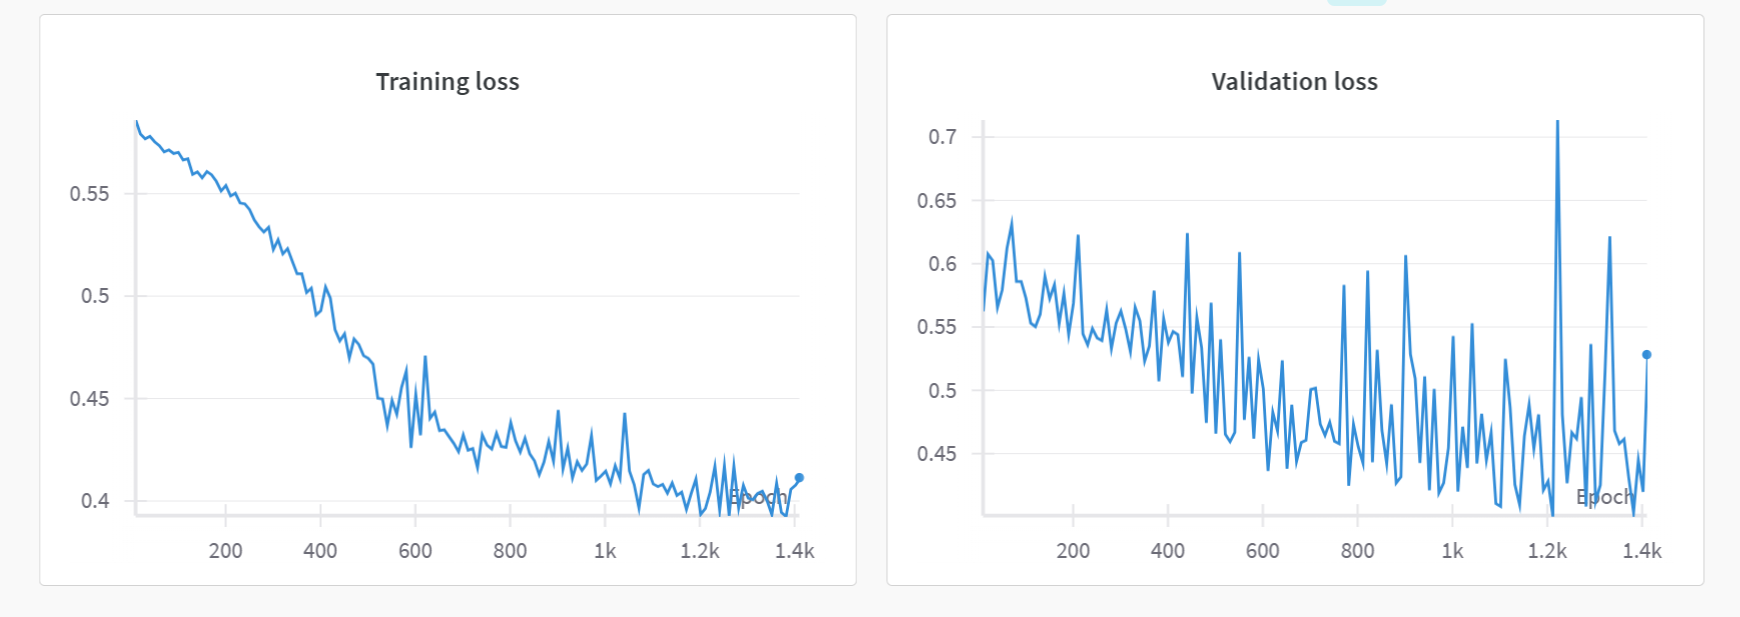

submission
---
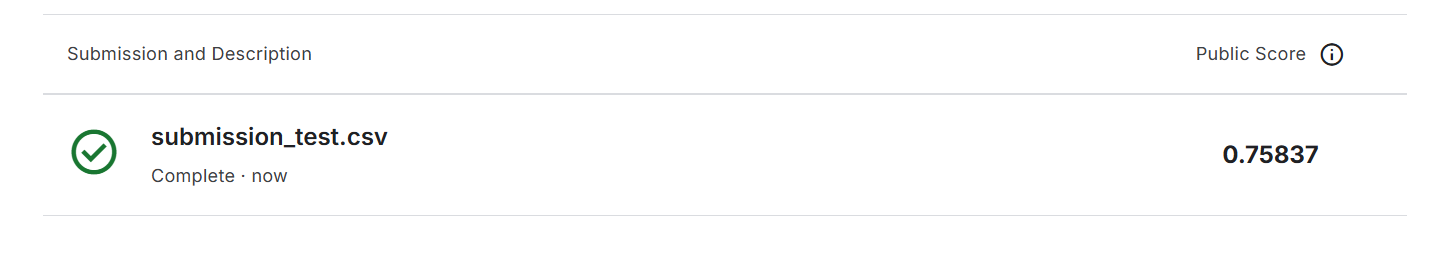

숙제 후기
---
활성함수들을 하나씩 적용해보며 각자의 loss를 체크하면서 느낀 점은, 결국 내가 하려는 예측에 제일 적합한 함수를 정하는 것도 
여러번 시도해 보면서 경험하는게 좋다고 생각하게 되었습니다. 예전에 다른 competition에 친구들과 도전하여 모델을 내려고 했었지만 쉽지 않아 결국 도중에 못했던 경험이 있었는데 이번 기회로 내가 작성한 csv를 제출하여 점수를 받으니 성취감을 느낀점도 좋았던거 같습니다. my모델을 작성하는 요령도 이번 과제를 통해 알 수 있게 되어 다음 과제가 진행 될 때에도 잘 활용 할 수 있을 것 같습니다. earlystop이 생각보다 유용한 것과 count를 생각보다도 많이 주어야 된다는 것도 이번기회를 통해 깨닫게 됐습니다.
